# Working with our Dataset

In [1]:
!pip install pandas
!pip install scikit-learn

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("bmh")

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv("visionarm_dataset_v01_01.csv")
data.head()

,left_thumb,left_index,left_middle,left_ring,left_pinky,right_thumb,right_index,right_middle,right_ring,right_pinky,target
0,0,0,1,1,1,0,0,0,0,0,invalid
1,1,1,1,1,1,0,0,0,0,0,grab
2,1,1,1,1,1,0,1,1,1,1,right
3,1,1,1,1,1,0,1,1,0,0,down
4,1,1,1,1,1,0,1,1,1,1,right


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   left_thumb    2000 non-null   int64 
 1   left_index    2000 non-null   int64 
 2   left_middle   2000 non-null   int64 
 3   left_ring     2000 non-null   int64 
 4   left_pinky    2000 non-null   int64 
 5   right_thumb   2000 non-null   int64 
 6   right_index   2000 non-null   int64 
 7   right_middle  2000 non-null   int64 
 8   right_ring    2000 non-null   int64 
 9   right_pinky   2000 non-null   int64 
 10  target        2000 non-null   object
dtypes: int64(10), object(1)
memory usage: 172.0+ KB


## Dealing with Missing values-
- We do not have any missing values in our data.
- However if we get any missing data values while real-time detection, we will impute it with 0 using imputer so that it becomes invalid and the robotic arm won't perform any operation for that particular input.

In [5]:
label_count = data['target'].value_counts()
label_count

target
invalid    600
grab       200
right      200
down       200
stop       200
left       200
drop       200
up         200
Name: count, dtype: int64

- Since we manually created our dataset I ensured that the 'invalid' label gets more samples because it has the most diverse combination set of data entries for each features

In [6]:
import json

# Load metadata file
with open("metadata.json", "r") as f:
    metadata = json.load(f)

# Access specific details
print("Dataset Name:", metadata["dataset_name"])
print("Version:", metadata["version"])
print("Total Samples:", metadata["num_samples"])
print("Labels:", metadata["target_labels"])
print("Feature Mapping (Example):", metadata["field_mapping"]["left_thumb"])

Dataset Name: visionarm_dataset_v01_01
Version: v01_01
Total Samples: 2000
Labels: ['stop', 'grab', 'drop', 'up', 'down', 'left', 'right', 'invalid']
Feature Mapping (Example): Left hand thumb (1=raised, 0=closed)


## Training SVM model

In [7]:
t = data['target'].copy()
X = data.drop(columns = ['target'])

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size = 0.2, random_state = 42, stratify = t, shuffle = True)
X_train.shape, X_test.shape, t_train.shape, t_test.shape

((1600, 10), (400, 10), (1600,), (400,))

In [10]:
# Building a pipeline with SVM classifier, although its not required but its a good practice
svm_pipeline = Pipeline([
    ('svm', SVC(kernel = 'linear', C = 1, random_state=42))
])
svm_pipeline.fit(X_train, t_train)

,steps,"[('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False


In [11]:
y_train_1 = svm_pipeline.predict(X_train)
y_test_1 = svm_pipeline.predict(X_test)
print("Training Accuracy:", accuracy_score(t_train, y_train_1))
print("Testing Accuracy:", accuracy_score(t_test, y_test_1))
print("Classification Report:\n", classification_report(t_train, y_train_1))
print("Classification Report:\n", classification_report(t_test, y_test_1))

Training Accuracy: 0.9975
Testing Accuracy: 0.985
Classification Report:
               precision    recall  f1-score   support

        down       0.99      1.00      1.00       160
        drop       0.99      1.00      1.00       160
        grab       1.00      1.00      1.00       160
     invalid       1.00      0.99      1.00       480
        left       1.00      1.00      1.00       160
       right       0.99      1.00      1.00       160
        stop       1.00      1.00      1.00       160
          up       0.99      1.00      1.00       160

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Classification Report:
               precision    recall  f1-score   support

        down       1.00      1.00      1.00        40
        drop       1.00      1.00      1.00        40
        grab       0.98      1.00      0.99        40
     invalid       1.00      0.95 

In [12]:
import joblib
# Save the trained model to a file
joblib.dump(svm_pipeline, './SVM_Models/trial_1_SVM_model.pkl')

['./SVM_Models/trial_1_SVM_model.pkl']

In [13]:
# Hyperparameter Tuning using GridSearchCV
svm_pipeline.get_params()

{'memory': None,
 'steps': [('svm', SVC(C=1, kernel='linear', random_state=42))],
 'transform_input': None,
 'verbose': False,
 'svm': SVC(C=1, kernel='linear', random_state=42),
 'svm__C': 1,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'linear',
 'svm__max_iter': -1,
 'svm__probability': False,
 'svm__random_state': 42,
 'svm__shrinking': True,
 'svm__tol': 0.001,
 'svm__verbose': False}

In [14]:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator = svm_pipeline, param_grid = param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, t_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.0s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.0s
[CV] END .....svm__C=0.1, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END .....svm__C=0.1, svm__gamma=scale, svm__kernel=poly; total time=   0.0s
[CV] END .....svm__C=0.1, svm__gamma=scale, svm_

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svm__C': [0.1, 1, ...], 'svm__gamma': ['scale', 'auto'], 'svm__kernel': ['linear', 'rbf', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [15]:
best_model = grid_search.best_estimator_
y_train_best = best_model.predict(X_train)
y_test_best = best_model.predict(X_test)
print("Best Model Training Accuracy:", accuracy_score(t_train, y_train_best))
print("Best Model Testing Accuracy:", accuracy_score(t_test, y_test_best))

Best Model Training Accuracy: 0.9975
Best Model Testing Accuracy: 1.0


In [16]:
print("Classification Report for Best Model on Training Data:\n", classification_report(t_train, y_train_best))

Classification Report for Best Model on Training Data:
               precision    recall  f1-score   support

        down       0.99      1.00      1.00       160
        drop       0.99      1.00      1.00       160
        grab       1.00      1.00      1.00       160
     invalid       1.00      0.99      1.00       480
        left       1.00      1.00      1.00       160
       right       0.99      1.00      1.00       160
        stop       1.00      1.00      1.00       160
          up       0.99      1.00      1.00       160

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [17]:
print("Classification Report for Best Model on Testing Data:\n", classification_report(t_test, y_test_best))

Classification Report for Best Model on Testing Data:
               precision    recall  f1-score   support

        down       1.00      1.00      1.00        40
        drop       1.00      1.00      1.00        40
        grab       1.00      1.00      1.00        40
     invalid       1.00      1.00      1.00       120
        left       1.00      1.00      1.00        40
       right       1.00      1.00      1.00        40
        stop       1.00      1.00      1.00        40
          up       1.00      1.00      1.00        40

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



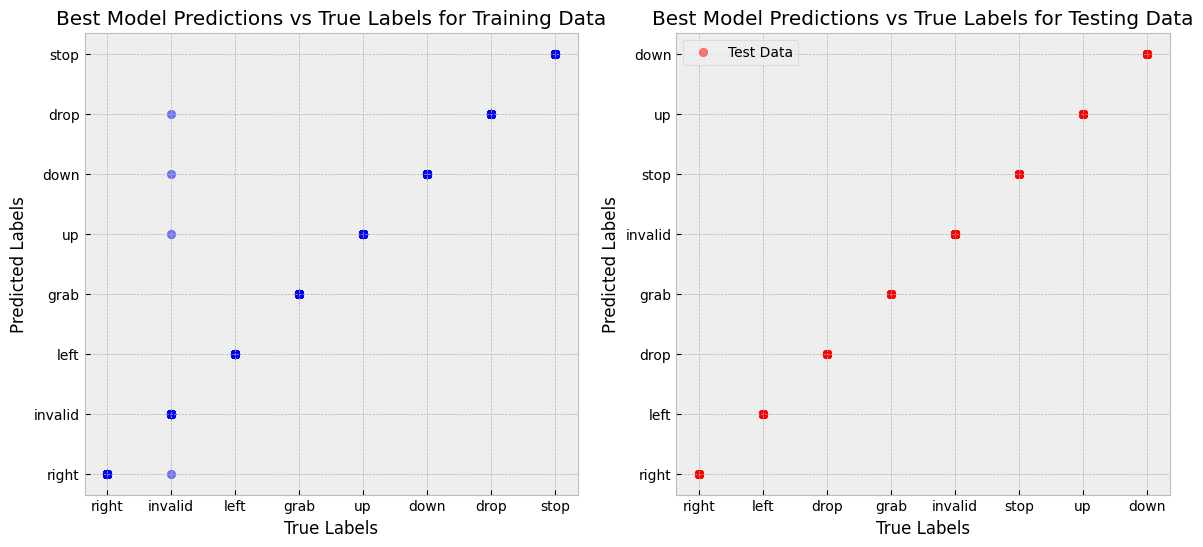

In [36]:
plt.figure(figsize = (14, 6))


plt.subplot(1, 2, 1)
plt.scatter(t_train, y_train_best, alpha = 0.5, color = 'blue', label = 'Train Data')
plt.title('Best Model Predictions vs True Labels for Training Data')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

plt.subplot(1, 2, 2)
plt.scatter(t_test, y_test_best, alpha = 0.5, color = 'red', label = 'Test Data')
plt.title('Best Model Predictions vs True Labels for Testing Data')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')


plt.legend()
plt.show()

## Testing our model on random Data Samples

In [25]:
# Testing our model on some random data points
input_data = np.array([[1, 1, 1, 1, 1, 0, 1, 0, 0, 0]])
prediction = best_model.predict(input_data)
print("Predicted class for input data is: ", prediction)

Predicted class for input data is:  ['up']


/Users/shivanshu_ade/Documents/anaconda3/envs/mp-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Dumping the model in our SVM_Model Folder for use in other files

In [26]:
# Dumping the best model after hyperparameter tuning
joblib.dump(best_model, './SVM_Models/best_label_classification_model.pkl')

['./SVM_Models/best_label_classification_model.pkl']